<a href="https://colab.research.google.com/github/RF-Lab/lab_sources/blob/master/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4%D1%8B_%D0%B8_%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC%D1%8B_%D1%86%D0%B8%D1%84%D1%80%D0%BE%D0%B2%D0%BE%D0%B9_%D0%BE%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B8_%D1%81%D0%B8%D0%B3%D0%BD%D0%B0%D0%BB%D0%BE%D0%B2_09_11_04_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 13:10-14:40 БИСО-1,2-16 Оптимальная фильтрация дискретных последовательностей. Метод наименьших квадратов.

**Лекция + Практическое занятие по дисциплине "Методы и алгоритмы цифровой обработки сигналов"**

*Кафедра КБ-3 "Управление и моделирование систем" Института Комплексной Безопасности и Специального Приборостроения, МИРЭА, 2020г.*

**Дата проведения занятия:** 11.04.2020.

**Время:** 13:10-14:40. 

**Место/Форма проведения занятия:** Дистанционное обучение/Конференция Skype. Ссылка на видео-конференцию будет предоставлена непосредственно перед занятием по почте.

**Постоянная ссылка:** https://colab.research.google.com/drive/1tojkXx4sjpNIsMuQVm8oGWhYnlXGfymF

**Цель:** Постановка задачи оптимальной фильтрации. Освоение метода наименьших квадратов и его применение для оптимальной фильтрации дискретных случайных последовательностей.

**Материал прошлых лекций**: В прошлых лекциях изучались свойства случайных дискретных последовательностей. В частности, необходимо помнить, что при сложении случайных независимых последовательностей складываются их дисперсии, в то время как при сложении детерминированных последовательностей складываюся их амплитуды. Это свойство позволяет накапливать энергию полезного сигнала в $N$ раз быстрее, чем накапливается энергия случайной составляющей. Помните, что **случайный сигнал нельзя предсказать**, следовательно, удаление случайной составляющей возможно только путем накопления энергии полезного сигнала при суммировании смеси (фильтрации).

*Рассмотрим задачу 1*:

Заданы тренировочные данные в виде трех последовательностей (выборок случайных процессов):

1) $\vec{a}$,т.ч. $a_n = \alpha x_n + \eta_n $

2) $\vec{b}$,т.ч. $b_n = \beta x_n + \xi_n $

3) $x_n$, $n\in 1\ldots N$ - полезный сигнал (считается известным на этапе обучения модели)

Требуется построить модель восстановления (оценивания) полезного ненаблюдаемого сигнала $x_n$ по двум наблюдаемым последовательностям $a_n$ и $b_n$ в виде модели:

$\hat{x}_n=c_1 a_n + c_2 b_n$

Такую модель в литературе называют моделью линейной регрессии, $a$ и $b$ -регрессорами, но это не важно, сосредоточимся на решении задачи 1.

Коэфициенты $\alpha$,$\beta$ не известны, параметры случайных последовательностей (шумов) $\eta_n$ и $\xi_n$ также не известны. 

Далее будем предполагать, что статистические характеристики шумов $\eta_n$ и $\xi_n$ не изменяются во времени. Т.е. $\eta$ и $\xi$ - это стационарные в широком смысле случайные процессы.

В такой постановке задача сводится к поиску коэффициентов $c_1$,$c_2$. Пока не задан критерй качества решения, задачу решить невозможно. Вместо того, чтобы формально вводить такой критерий - рассмотрим геометрическую интерпретацию этой задачи и введем критерий осознанно, но перед этим сгенерируем данные.

Пример формирования таких последовательностей приведен ниже:

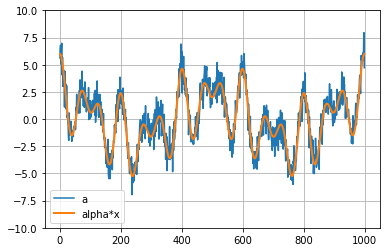

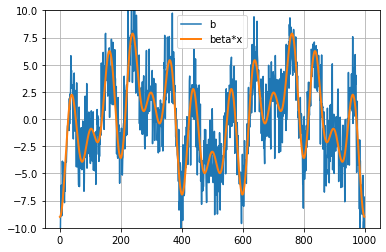

In [0]:
import numpy as np
import matplotlib.pyplot as plt

N     = 1000
alpha = 2
beta  = -3
x     = np.cos( np.pi/N*4*np.arange(0.,N) )+np.cos( np.pi/N*20*np.arange(0.,N) )+np.cos( np.pi/N*30*np.arange(0.,N) )
eta   = 0.9 * np.random.randn( N )
xi    = 2.1 * np.random.randn( N )
a     = alpha*x + eta
b     = beta*x + xi

plt.figure()
plt.plot( a,label='a' )
plt.plot( x*alpha, label='alpha*x',linewidth=2 )
plt.ylim(-10,10)
plt.grid(True)
plt.legend()

plt.figure()
plt.plot( b,label='b' )
plt.plot( x*beta,label='beta*x',linewidth=2 )
plt.ylim(-10,10)
plt.grid(True)
plt.legend()

Рассмотрим геометрическую интерпретацию задачи 1. 

$\hat{\vec{x}}=c_1 \vec{a} + c_2 \vec{b}$

Пусть, например, выборки $a_n$ и $b_n$ содержат по два элемента 
$\vec{a}=\begin{pmatrix}
a_1 \\
a_2 \\
\end{pmatrix}$ и 
$\vec{b}=\begin{pmatrix}
b_1 \\
b_2 \\
\end{pmatrix}$.
В идеальном мире мы потребовали бы чтобы оценка была равна истинному вектору, т.е. $\hat{\vec{x}}=\vec{x}$. Такая наивная постановка приводит к системе из двух уравнений с двумя неизвестными $c_{1,2}$:

$
c_1\begin{pmatrix}
a_1 \\
a_2 \\
\end{pmatrix}+ 
c_2\begin{pmatrix}
b_1 \\
b_2 \\
\end{pmatrix}=
\begin{pmatrix}
a_1 & b_1\\
a_2 & b_2\\
\end{pmatrix} 
\begin{pmatrix}
c_1 \\
c_2 \\
\end{pmatrix}=
\begin{pmatrix}
x_1 \\
x_2 \\
\end{pmatrix}
$

Эту задачу можно изобразить графически:

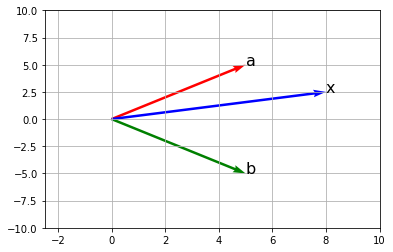

In [0]:
import numpy as np
import matplotlib.pyplot as plt

a   = [5, 5] 
b   = [5,-5]
x   = [8,2.5]

plt.quiver([0, 0, 0], [0, 0, 0], [a[0], b[0], x[0]], [a[1], b[1], x[1]], angles='xy', scale_units='xy', scale=1, color=['r','g','b'])
plt.text( *a, 'a', fontsize=16 )
plt.text( *b, 'b', fontsize=16 )
plt.text( *x, 'x', fontsize=16 )
plt.xlim(-2.5, 10)
plt.ylim(-10, 10)
plt.grid(True)

Требуется подобрать такие коэффициенты $c_1$ и $c_2$ для векторов $\vec{a}$ и $\vec{b}$, чтобы сумма $c_1\vec{a}+c_2\vec{b}=\vec{x}$. Формальное решение этой задачи:

$
\begin{pmatrix}
c_1 \\
c_2 \\
\end{pmatrix}=
\begin{pmatrix}
a_1 & b_1\\
a_2 & b_2\\
\end{pmatrix}
^{-1} 
\begin{pmatrix}
x_1 \\
x_2 \\
\end{pmatrix}
$


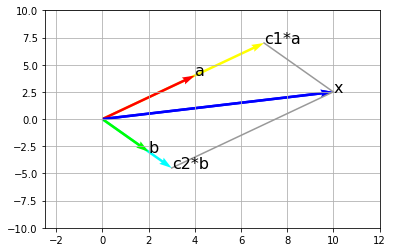

In [0]:
import numpy as np
import matplotlib.pyplot as plt

a         = np.array([[4.], [4.]]) 
b         = np.array([[2.],[-3.]])
x         = np.array([[10.],[2.5]])

# solve c
c         = np.linalg.inv( np.hstack((a,b))) @ x
origin    = np.zeros((2,3))
vectors   = np.hstack((a,b,x))
vectorsc  = np.hstack((a*c[0],b*c[1],x))

plt.quiver( *origin,*vectorsc, angles='xy', scale_units='xy', scale=1, color=[[1, 1, 0],[0, 1, 1],[0,0,1]])
plt.quiver( *origin,*vectors, angles='xy', scale_units='xy', scale=1, color=[[1, 0, 0],[0, 1, 0],[0,0,1]])
plt.text( *a, 'a', fontsize=16 )
plt.text( *a*c[0], 'c1*a', fontsize=16 )
plt.text( *b*c[1], 'c2*b', fontsize=16 )
plt.text( *b, 'b', fontsize=16 )
plt.text( *x, 'x', fontsize=16 )
plt.xlim(-2.5, 12)
plt.ylim(-10, 10)
plt.plot( [c[0]*a[0], x[0]], [c[0]*a[1], x[1]],color=[0.6, 0.6, 0.6] )
plt.plot( [c[1]*b[0], x[0]], [c[1]*b[1], x[1]],color=[0.6, 0.6, 0.6] )
plt.grid(True)

В данном случае было получено точное решение. Теперь рассмотрим случай, когда векторы $\vec{a}$ и $\vec{b}$ лежат на одной прямой.

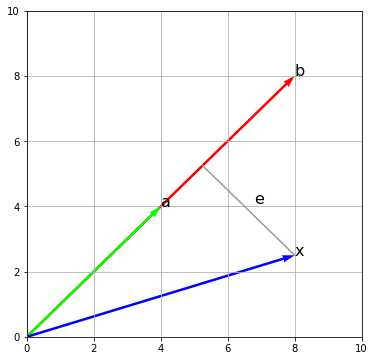

In [6]:
import numpy as np
import matplotlib.pyplot as plt

a         = np.array([[4.], [4.]]) 
b         = np.array([[8.],[8.]])
x         = np.array([[8.],[2.5]])

# solve c
origin    = np.zeros((2,3))
vectors   = np.hstack((b,a,x))

Y         = np.hstack((a,b))

c         = np.linalg.pinv( Y.transpose() @ Y ) @ Y.transpose() @ x
y         = Y@c

plt.figure(figsize=(6,6))
plt.quiver( *origin,*vectors, angles='xy', scale_units='xy', scale=1, color=[[1, 0, 0],[0, 1, 0],[0,0,1]])
plt.text( *a, 'a', fontsize=16 )
plt.text( *b, 'b', fontsize=16 )
plt.text( *x, 'x', fontsize=16 )
plt.text( 6.8,4.1, 'e', fontsize=16 )
plt.plot( [x[0], y[0]], [x[1], y[1]],color=[0.6, 0.6, 0.6] )
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.grid(True)

В этом случае точное решение получить не представляется возможным. Результат сложения векторов $c_1 \vec{a} + c_2 \vec{b}$ будет сонаправлен с векторами $\vec{a}$, $\vec{b}$, т.е. решение будет лежать на прямой совпадающей с этими векторами. 

Множество элементов векторного пространства, образованное линейной формой вида $c_1 \vec{a} + c_2 \vec{b}$ $\forall c_1,c_2$ называется **линейной оболочкой** для векторов $\vec{a}$, $\vec{b}$. В данном случае, линейная оболочка - это прямая совпадающая с векторами $\vec{a}$, $\vec{b}$.

Т.е. линейная оболочка - это множество всех выходов которые может сформировать линейная модель. В нашем примере линейная оболочка геометрически определяет одномерное пространство - для точного определения положения на прямой достаточно одного числа. Требуемое решение $x$ лежит вне этого одномерного пространства в двумерном пространстве. 

Эта ситуация, когда линейная оболочка модели не охватывает требуемое решение - довольно типичная. Мы часто пытаемся сделать модель как можно более компактной, с небольшим количеством регрессоров (векторов, подобных $\vec{a}$, $\vec{b}$). В то же время размерность этих векторов может быть гораздо больше их используемого в модели количества. При этом возникает **переопределенная** система линейных уравнений, т.е. количество уравнений (равная количеству элементов в в векторах) превышает количество неизвестных коэффициентов $c_k$ (количество векторов-регрессоров). 

Несмотря на то, что получить точное решение в такой постановке нельзя, можно найти ближайшую к $\vec{x}$ точку линейной оболочки. Из школьного курса геометрии известно, что кратчайшее расстояние от точки до прямой определяется перпендикуляром от конца вектора $\vec{x}$ к прямой определяющей линейную оболочку. 

Формально можем записать так: 

$\min\limits_{c_1,c_2}\|\vec{e}\|_2=\min\limits_{c_1,c_2}\vec{e}^T\vec{e}$

$\vec{e}(c_1,c_2)=(c_1 \vec{a} + c_2 \vec{b})-\vec{x}$

Можно найти градиент функции $\nabla\left(\vec{e}^T\vec{e}\right)=\left(\frac{\partial\vec{e}^T\vec{e}}{\partial c_1},\frac{\partial\vec{e}^T\vec{e}}{\partial c_2}\right)$ и приравнять его к нулевому вектору (*объясните почему*). Тогда получим систему так называемых **нормальных уравнений**.

Упростим наши рассуждения, нам известно, что вектор ошибки $\vec{e}$ должен быть перпендикулярен линейной оболочке, т.е. скалярные произведения каждого из векторов-регрессоров с вектором ошибки должны быть равны нулю (*Почему?*):

$
\begin{pmatrix}
a_1 & b_1\\
a_2 & b_2\\
\end{pmatrix}
^{T} 
\left[
\begin{pmatrix}
a_1 & b_1\\
a_2 & b_2\\
\end{pmatrix} 
\begin{pmatrix}
c_1 \\
c_2 \\
\end{pmatrix}-
\begin{pmatrix}
x_1 \\
x_2 \\
\end{pmatrix}
\right]=
\begin{pmatrix}
0 \\
0 \\
\end{pmatrix}
$

Преобразуем

$
\begin{pmatrix}
a_1 & b_1\\
a_2 & b_2\\
\end{pmatrix}
^{T} 
\begin{pmatrix}
a_1 & b_1\\
a_2 & b_2\\
\end{pmatrix} 
\begin{pmatrix}
c_1 \\
c_2 \\
\end{pmatrix}=
\begin{pmatrix}
a_1 & b_1\\
a_2 & b_2\\
\end{pmatrix}
^{T} 
\begin{pmatrix}
x_1 \\
x_2 \\
\end{pmatrix}
$

Получим:

$
\begin{pmatrix}
c_1 \\
c_2 \\
\end{pmatrix}=
\left[
\begin{pmatrix}
a_1 & b_1\\
a_2 & b_2\\
\end{pmatrix}
^{T} 
\begin{pmatrix}
a_1 & b_1\\
a_2 & b_2\\
\end{pmatrix}
\right]^{-1} 
\begin{pmatrix}
a_1 & b_1\\
a_2 & b_2\\
\end{pmatrix}
^{T} 
\begin{pmatrix}
x_1 \\
x_2 \\
\end{pmatrix}
$

Такой способ нахождения параметров модели (способ решения переопределенной линейной системы) называется **методом наименьших квадратов (МНК)**. Впервые этот метод был предложен Гауссом, но в дальнейшем был переоткрыт рядом ученых. Наиболее распространенной формулой, представляющей сегодня метод МНК является:

$\vec{c}=(V^TV)^{-1}V^Tx$

где матрица $V$ составлена из векторов-регрессоров (таких как $\vec{a}$,$\vec{b}$).

При этом матрица 

$(V^TV)^{-1}V^T$

называется *псевдообратной матрицей* или матрицей *Мура-Пенроуза*.

Пользуясь МНК решим нашу самую первую задачу 1:

c=[[ 0.32125308]
 [-0.09214418]]


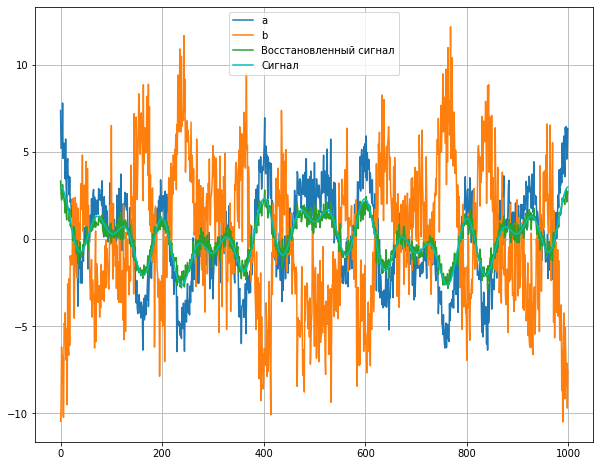

In [26]:
import numpy as np
import matplotlib.pyplot as plt

N     = 1000
alpha = 2
beta  = -3
x     = np.array([np.cos( np.pi/N*4*np.arange(0.,N) )+np.cos( np.pi/N*20*np.arange(0.,N) )+np.cos( np.pi/N*30*np.arange(0.,N) )]).transpose()
eta   = 0.9 * np.random.randn( N,1 )
xi    = 2.1 * np.random.randn( N,1 )
a     = alpha*x + eta
b     = beta*x + xi

V     = np.hstack((a,b))
c     = np.linalg.inv(V.transpose()@V)@V.transpose()@x
print('c={0}'.format(c))

sol_x = V@c

plt.figure(figsize=(10,8))
plt.plot( a,label='a' )
plt.plot( b,label='b' )
plt.plot( sol_x,label='Восстановленный сигнал' )
plt.plot( x,color='c',label='Сигнал' )
plt.grid(True)
plt.legend()

Следующая лекция будет посвящена анализу остаточной (неустранимой) ошибки.